<a href="https://colab.research.google.com/github/VictorFrancheto/Complex_Network/blob/main/Prova_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalando a biblioteca `graph-tool`(https://graph-tool.skewed.de)

In [1]:
!mkdir -p /etc/apt/keyrings; mkdir -p ~/.gnupg; chmod 700 ~/.gnupg
!gpg --no-default-keyring --keyring /etc/apt/keyrings/skewed.de.gpg --keyserver keyserver.ubuntu.com --recv-keys 612DEFB798507F25
!echo "deb [signed-by=/etc/apt/keyrings/skewed.de.gpg] https://downloads.skewed.de/apt $(lsb_release -s -c) main" > /etc/apt/sources.list.d/skewed.list
!apt-get update
!apt-get install python3-graph-tool python3-matplotlib python3-cairo

gpg: key 612DEFB798507F25: "Tiago de Paula Peixoto <tiago@skewed.de>" not changed
gpg: Total number processed: 1
gpg:              unchanged: 1
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Ign:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://downloads.skewed.de/apt jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,370 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,593 kB]
Hit:13 https:

In [2]:
# O Colab usa uma instalação Python diferente da do sistema! Colaboração ruim! Precisamos de algumas soluções alternativas.
!apt purge python3-cairo
!apt install libcairo2-dev pkg-config python3-dev
!pip install --force-reinstall pycairo
!pip install zstandard

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following packages were automatically installed and are no longer required:
  libbz2-dev libpkgconf3 libreadline-dev
Use 'apt autoremove' to remove them.
The following packages will be REMOVED:
  python3-cairo*
0 upgraded, 0 newly installed, 1 to remove and 47 not upgraded.
After this operation, 310 kB disk space will be freed.
(Reading database ... 132780 files and directories currently installed.)
Removing python3-cairo:amd64 (1.20.1-3build1) ...
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libcairo2-dev is already the newest version (1.16.0-5ubuntu2).
pkg-config is already the newest version (0.29.2-1ubuntu3).
python3-dev is already the newest version (3.10.6-1~22.04.1).
The following packages were automatically installed and are no longer required:
  libbz2-dev libpkgconf3 libreadline-dev
Use 'apt autoremove' to remove them.
0 upgr

### Agora podemos usar a ferramenta gráfica como qualquer outro módulo Python

In [3]:
import graph_tool.all as gt

#### Importando bibliotecas

In [4]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
import itertools

# Importando os métodos de detecção de comunidades do NetworkX
from networkx.algorithms import community as nx_comm
from networkx.algorithms.community import (
    greedy_modularity_communities,  # Método Modularity Greedy
    louvain_communities,            # Método Louvain nativo do NetworkX
    girvan_newman,                  # Método de Girvan-Newman
    label_propagation_communities   # Método de Propagação de Rótulos
)

# Importando o método de Louvain correto do pacote 'community'
import community.community_louvain as community_louvain


#### Função para ler as redes

In [20]:
def process_graph(graph_name, directed=True):
    """
    Processa um grafo da coleção Graph-tool, convertendo-o para um grafo NetworkX,
    removendo auto-laços e imprimindo o número de nós e arestas.

    Parâmetros:
    graph_name (str): Nome do grafo na coleção Graph-tool.
    directed (bool): Se True, cria um grafo direcionado; se False, cria um grafo não direcionado.
    """
    # Carregar o grafo do graph-tool
    G_gt = gt.collection.ns[graph_name]

    # Criar um grafo vazio do NetworkX, direcionado ou não
    G_nx = nx.DiGraph() if directed else nx.Graph()

    # Adicionar arestas do grafo do Graph-tool para o grafo do NetworkX
    for edge in G_gt.edges():
        G_nx.add_edge(edge.source(), edge.target())

    # Remover auto-laços
    G_nx.remove_edges_from(nx.selfloop_edges(G_nx))

    # Ajustando as labels
    G_nx = nx.convert_node_labels_to_integers(G_nx, first_label=0)

    # Obtendo o maior componente conectado
    Gcc = sorted(nx.connected_components(G_nx), key=len, reverse=True)
    G_nx = G_nx.subgraph(Gcc[0])

    # Imprimir o número de nós e arestas
    print(f"Grafo: {graph_name}")
    print("Número de nós:", G_nx.number_of_nodes())
    print("Número de arestas:", G_nx.number_of_edges())

    return G_nx  # Retorna o grafo processado

#### Plotando as redes

Grafo: karate/78
Número de nós: 34
Número de arestas: 78
Grafo: football
Número de nós: 115
Número de arestas: 613
Grafo: polbooks
Número de nós: 105
Número de arestas: 441


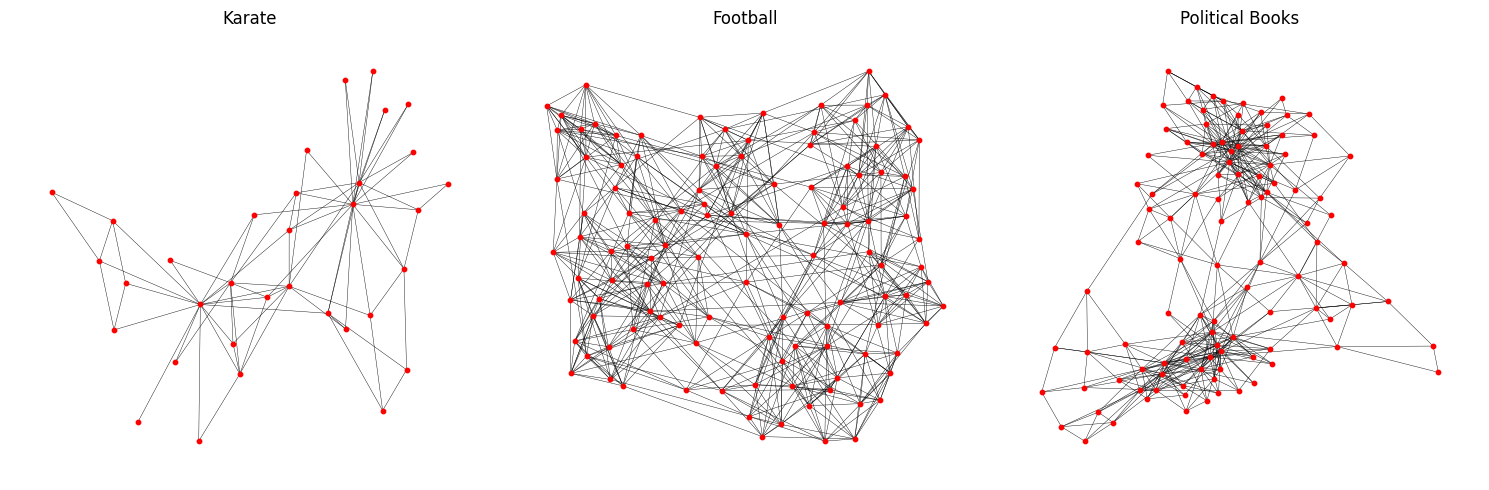

In [21]:
def plot_graph(G_nx, ax, title):
    """
    Função para plotar um grafo em um eixo específico.

    Parâmetros:
    G_nx (networkx.Graph): O grafo a ser plotado.
    ax (matplotlib.Axes): O eixo onde o grafo será plotado.
    title (str): O título do grafo.
    """
    pos = nx.spring_layout(G_nx)  # Definir a disposição do grafo
    nx.draw(
        G_nx, pos,
        ax=ax,
        with_labels=False,  # Remover rótulos
        node_color='red',  # Cor dos nós
        edge_color='black',  # Cor das arestas
        node_size=10,  # Tamanho dos nós
        width=0.3,  # Largura das arestas
        font_size=8,  # Tamanho da fonte dos rótulos
        font_weight='bold',
        arrows=False  # Desabilitar setas para grafos não direcionados
    )
    ax.set_title(title)  # Título do subplot
    ax.axis('off')  # Ocultar os eixos para melhor visualização

# Criar a figura com 3 subplots lado a lado
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))  # 3 colunas para os subplots

# Processar e plotar os grafos
#G_facebook = process_graph('facebook_friends', directed=False)
G_karate = process_graph('karate/78', directed=False)
G_football = process_graph('football', directed=False)
G_polbooks = process_graph('polbooks', directed=False)

plot_graph(G_karate, axs[0], "Karate")
plot_graph(G_football, axs[1], "Football")
plot_graph(G_polbooks, axs[2], "Political Books")

# Mostrar o gráfico
plt.tight_layout()  # Ajustar espaçamento entre os subplots
plt.show()


# Exercício 1:
Busque 3 redes complexas modelando sistemas reais que possivelmente apresentem estruturas de comunidades. Selecione 3 métodos de detecção de coumidades e identifique as comunidades destas redes.

$a)$ Mostre as comunidades identificadas em cada uma das redes;\
$b)$ Calcule o número de comunidades encontradas em cada uma das redes;\
$c)$ Clacule o valor de modularidade em cada uma das redes. É possível comparar o desempenho de um mesmo método entre redes distintas usando modularidade?\
$d)$ Calcule o quão similar são as patições encontradas por diferentes algorimtos na mesma rede;\
$e)$ Opicional: As inconsistências do item anterior ocorrem na borda das comunidades?

-------------

In [22]:
# Função para desenhar o grafo com as comunidades detectadas
def plot_communities(G_nx, communities, ax, title):
    """
    Função para plotar um grafo com as comunidades detectadas.

    Parâmetros:
    G_nx (networkx.Graph): O grafo a ser plotado.
    communities (list or dict): Comunidades identificadas, pode ser uma lista de conjuntos ou dicionário de rótulos.
    ax (matplotlib.Axes): O eixo onde o grafo será plotado.
    title (str): O título do grafo.
    """
    pos = nx.spring_layout(G_nx)  # Definir a disposição do grafo

    # Se comunidades for um dicionário (ex: Louvain), converta para lista de listas
    if isinstance(communities, dict):
        community_map = communities
    else:
        # Caso contrário, é uma lista de conjuntos (Girvan-Newman e Label Propagation)
        community_map = {node: idx for idx, community in enumerate(communities) for node in community}

    # Extrair as cores com base nas comunidades
    community_values = [community_map[node] for node in G_nx.nodes()]
    num_communities = len(set(community_values))

    # Escolher um conjunto de cores
    cmap = plt.cm.get_cmap('rainbow', num_communities)

    nx.draw(
        G_nx, pos,
        ax=ax,
        node_color=community_values,  # Colorir nós de acordo com a comunidade
        cmap=cmap,  # Usar colormap apropriado
        with_labels=False,  # Remover rótulos
        node_size=50,  # Tamanho dos nós
        edge_color='black',  # Arestas na cor preta
        width=0.5  # Largura das arestas
    )
    ax.set_title(title)  # Título do subplot
    ax.axis('off')  # Ocultar os eixos para melhor visualização

# Função para exibir as comunidades detectadas
def print_communities(communities, method_name):
    """
    Função para printar as comunidades em formato legível.

    Parâmetros:
    communities (list ou dict): Comunidades detectadas.
    method_name (str): Nome do método de detecção de comunidades.
    """
    print(f"\nComunidades detectadas pelo método: {method_name}")

    if isinstance(communities, dict):  # Para Louvain (dicionário)
        # Converter dicionário em lista de listas
        comm_map = {}
        for node, comm in communities.items():
            if comm not in comm_map:
                comm_map[comm] = []
            comm_map[comm].append(node)
        communities = list(comm_map.values())

    # Corrigir caso os nós sejam objetos (ex: Vertex)
    for i, community in enumerate(communities, 1):
        node_ids = [v.index if hasattr(v, 'index') else v for v in community]  # Extraindo IDs corretos
        print(f"Comunidade {i}: {sorted(node_ids)}")

# Aplicar os métodos de detecção de comunidades
def detect_communities_louvain(G_nx):
    """
    Método de detecção de comunidades utilizando o algoritmo Louvain.
    """
    return community_louvain.best_partition(G_nx)

def detect_communities_girvan_newman(G_nx):
    """
    Método de detecção de comunidades utilizando o algoritmo Girvan-Newman.
    """
    comp = girvan_newman(G_nx)
    limited = itertools.takewhile(lambda c: len(c) <= 10, comp)  # Limitar para não ter muitas divisões
    return next(limited)

def detect_communities_label_propagation(G_nx):
    """
    Método de detecção de comunidades utilizando o algoritmo de Propagação de Rótulos.
    """
    return list(label_propagation_communities(G_nx))

#### Comunidades na rede Karate


Comunidades detectadas pelo método: Louvain (Karate)
Comunidade 1: [0, 1, 2, 3, 7, 10, 11, 12, 13, 14, 15, 18]
Comunidade 2: [4, 5, 6, 9, 22]
Comunidade 3: [8, 17, 21, 23, 24, 27, 29, 30, 31, 32, 33]
Comunidade 4: [16, 19, 20, 25, 26, 28]

Comunidades detectadas pelo método: Girvan Newman (Karate)
Comunidade 1: [0, 1, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 22]
Comunidade 2: [2, 8, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]

Comunidades detectadas pelo método: Label Propagation (Karate)
Comunidade 1: [0, 1, 2, 3, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
Comunidade 2: [4, 9]
Comunidade 3: [5, 6, 22]


<ipython-input-24-a5b9640f469d>:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('rainbow', num_communities)


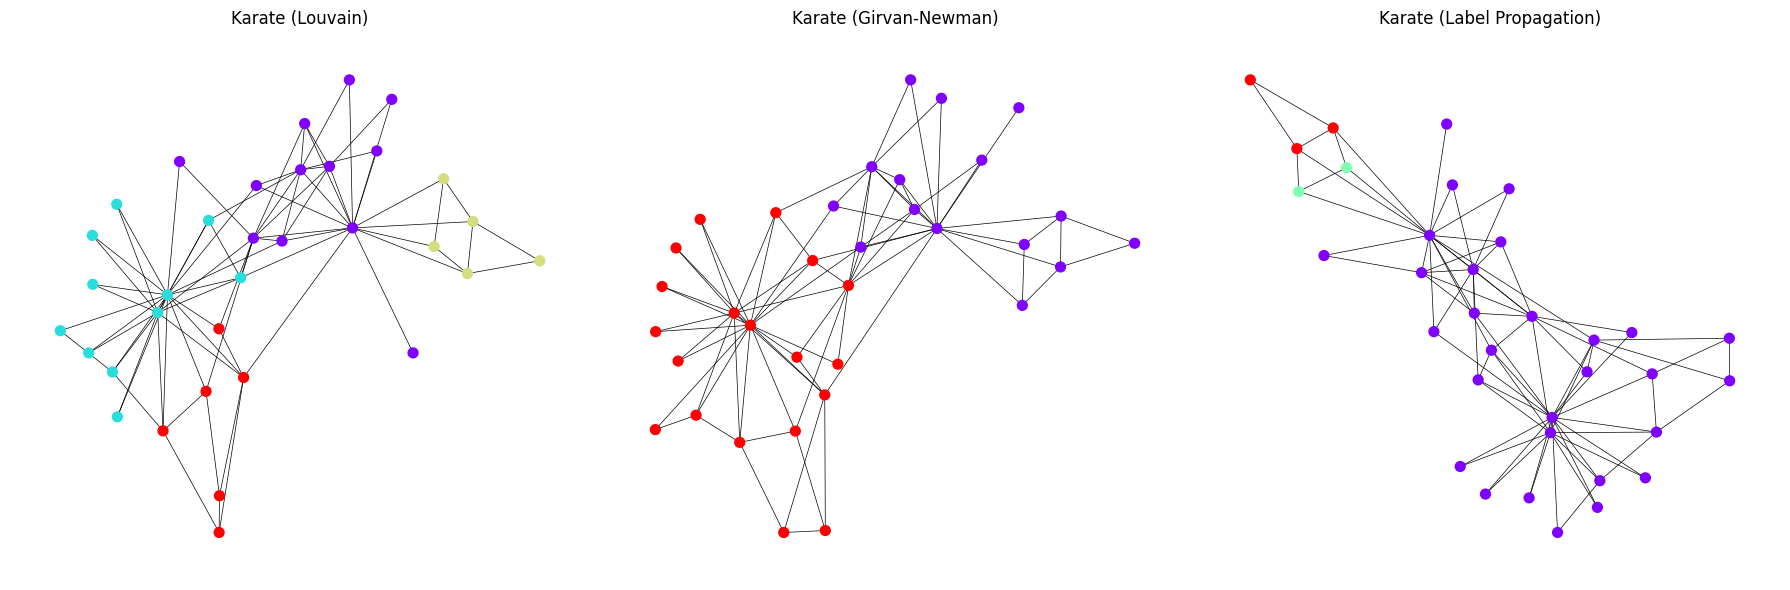

In [26]:
# Criar a figura com 3 subplots lado a lado
fig, axs = plt.subplots(ncols=3, figsize=(18, 6))  # 3 colunas para os subplots

# Detectar comunidades usando diferentes métodos
communities_karate_l = detect_communities_louvain(G_karate)
communities_karate_g = detect_communities_girvan_newman(G_karate)
communities_karate_p = detect_communities_label_propagation(G_karate)

# Printando as comunidades
print_communities(communities_karate_l, "Louvain (Karate)")
print_communities(communities_karate_g, "Girvan Newman (Karate)")
print_communities(communities_karate_p, "Label Propagation (Karate)")

# Plotar os grafos com as comunidades
plot_communities(G_karate, communities_karate_l, axs[0], "Karate (Louvain)")
plot_communities(G_karate, communities_karate_g, axs[1], "Karate (Girvan-Newman)")
plot_communities(G_karate, communities_karate_p, axs[2], "Karate (Label Propagation)")

# Mostrar o gráfico
plt.tight_layout()  # Ajustar espaçamento entre os subplots
plt.show()

#### Comunidade football


Comunidades detectadas pelo método: Louvain (Football)
Comunidade 1: [0, 25, 33, 37, 45, 89, 103, 105, 109]
Comunidade 2: [1, 4, 9, 11, 16, 23, 24, 28, 41, 50, 69, 90, 93, 104]
Comunidade 3: [2, 5, 10, 40, 52, 72, 74, 81, 84, 98, 102, 107]
Comunidade 4: [3, 6, 12, 15, 32, 39, 47, 60, 64, 100, 106]
Comunidade 5: [7, 8, 21, 22, 51, 68, 77, 78, 108, 111]
Comunidade 6: [13, 14, 18, 26, 31, 34, 36, 38, 42, 43, 54, 61, 71, 85, 99]
Comunidade 7: [17, 20, 27, 56, 58, 59, 62, 63, 65, 70, 76, 87, 95, 96, 97, 113]
Comunidade 8: [19, 29, 30, 35, 55, 79, 80, 82, 94, 101]
Comunidade 9: [44, 48, 57, 66, 75, 86, 91, 92, 112]
Comunidade 10: [46, 49, 53, 67, 73, 83, 88, 110, 114]

Comunidades detectadas pelo método: Girvan Newman (Football)
Comunidade 1: [0, 13, 14, 17, 18, 19, 20, 25, 26, 27, 29, 30, 31, 33, 34, 35, 36, 37, 38, 42, 43, 44, 45, 48, 54, 55, 56, 57, 58, 59, 61, 62, 63, 65, 66, 70, 71, 75, 76, 79, 80, 85, 86, 87, 89, 91, 92, 94, 95, 96, 97, 99, 101, 103, 105, 109, 112, 113]
Comunidade 2: 

<ipython-input-24-a5b9640f469d>:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('rainbow', num_communities)


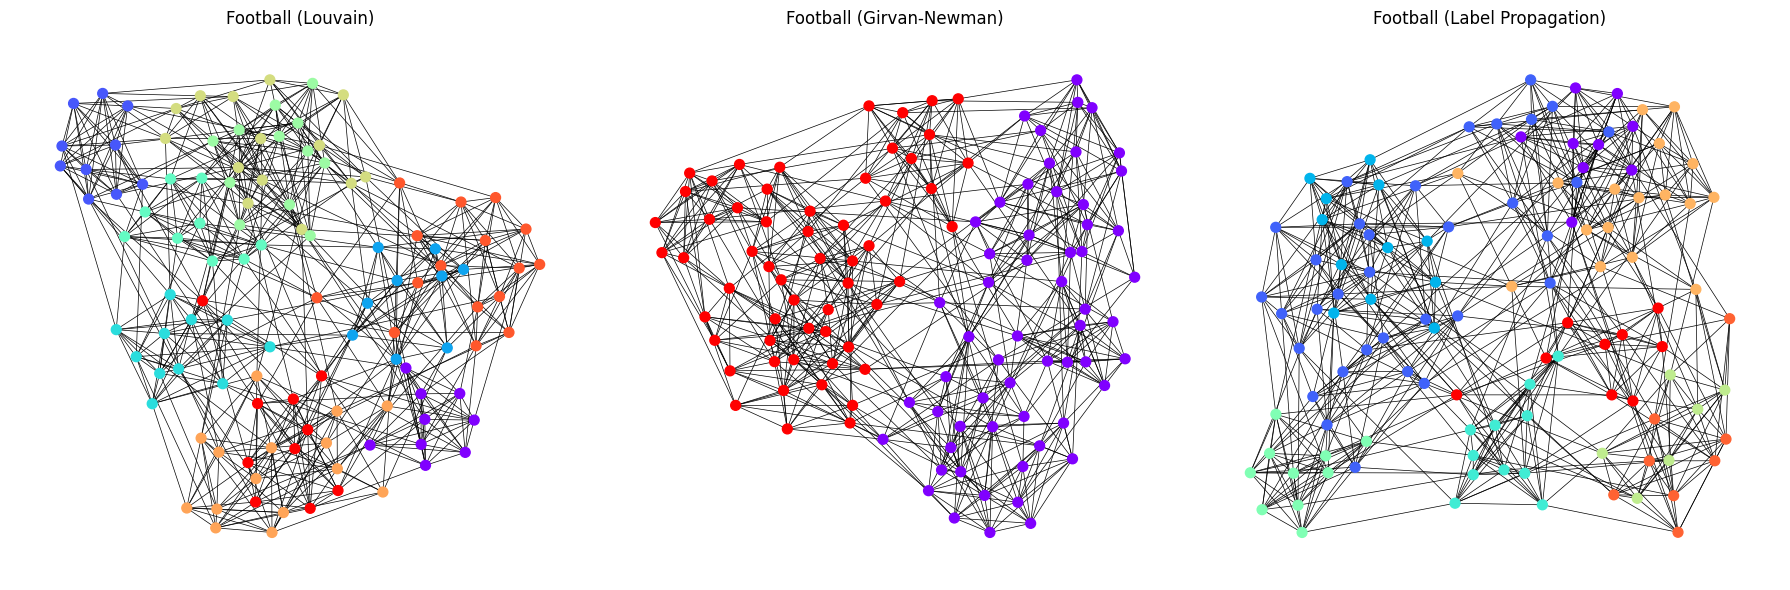

In [27]:
# Criar a figura com 3 subplots lado a lado
fig, axs = plt.subplots(ncols=3, figsize=(18, 6))  # 3 colunas para os subplots

# Detectar comunidades usando diferentes métodos
communities_football_l = detect_communities_louvain(G_football)
communities_football_g = detect_communities_girvan_newman(G_football)
communities_football_p = detect_communities_label_propagation(G_football)


# Printando as comunidades
print_communities(communities_football_l, "Louvain (Football)")
print_communities(communities_football_g, "Girvan Newman (Football)")
print_communities(communities_football_p, "Label Propagation (Football)")

# Plotar os grafos com as comunidades
plot_communities(G_football, communities_football_l, axs[0], "Football (Louvain)")
plot_communities(G_football, communities_football_g, axs[1], "Football (Girvan-Newman)")
plot_communities(G_football, communities_football_p, axs[2], "Football (Label Propagation)")

# Mostrar o gráfico
plt.tight_layout()  # Ajustar espaçamento entre os subplots
plt.show()


Comunidades detectadas pelo método: Louvain (Polbooks)
Comunidade 1: [0, 1, 2, 4, 5, 6, 7, 29]
Comunidade 2: [3, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 50, 53, 54, 55, 56]
Comunidade 3: [28, 30, 31, 59, 60, 61, 62, 63, 66, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102]
Comunidade 4: [48, 49, 57]
Comunidade 5: [51, 52, 58, 64, 65, 67, 68, 69, 85, 103, 104]

Comunidades detectadas pelo método: Girvan Newman (Polbooks)
Comunidade 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 64, 65, 68, 69]
Comunidade 2: [28, 30, 31, 59, 60, 61, 62, 63, 66, 67, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 

<ipython-input-24-a5b9640f469d>:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('rainbow', num_communities)


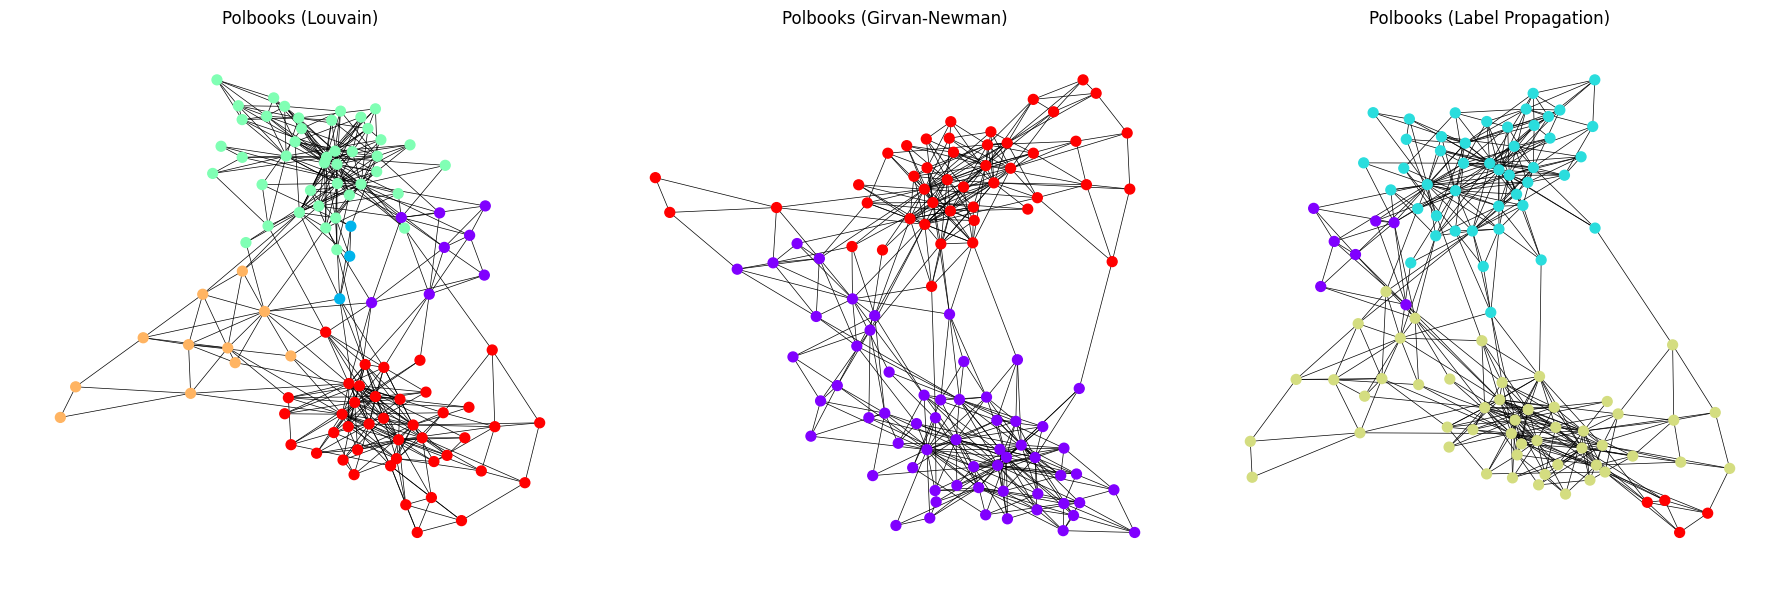

In [28]:
# Criar a figura com 3 subplots lado a lado
fig, axs = plt.subplots(ncols=3, figsize=(18, 6))  # 3 colunas para os subplots

# Detectar comunidades usando diferentes métodos
communities_polbooks_l = detect_communities_louvain(G_polbooks)
communities_polbooks_g = detect_communities_girvan_newman(G_polbooks)
communities_polbooks_p = detect_communities_label_propagation(G_polbooks)


# Printando as comunidades
print_communities(communities_polbooks_l, "Louvain (Polbooks)")
print_communities(communities_polbooks_g, "Girvan Newman (Polbooks)")
print_communities(communities_polbooks_p, "Label Propagation (Polbooks)")


# Plotar os grafos com as comunidades
plot_communities(G_polbooks, communities_polbooks_l, axs[0], "Polbooks (Louvain)")
plot_communities(G_polbooks, communities_polbooks_g, axs[1], "Polbooks (Girvan-Newman)")
plot_communities(G_polbooks, communities_polbooks_p, axs[2], "Polbooks (Label Propagation)")

# Mostrar o gráfico
plt.tight_layout()  # Ajustar espaçamento entre os subplots
plt.show()

#Letra c) Cálculo da modularidade